## ERDAP with erddapy example for ITAE Prawler - 2018 St Matt's (MTITAEPR-1A)

***requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)

In [26]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2018-07-12 08:45:59.283344


### connecting and basic information

In [27]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [28]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

In [29]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 8 tabledap, 0 griddap, and 0 wms endpoints.'

In [30]:
prawlers = df['Dataset ID'].values
print(prawlers)

['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler' 'erddap_17ckitaem2a_met'
 'erddap_18bsitaepr2a_met' 'erddap_18mtitaepr1a_met']


In [31]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['time', 'longitude', 'Salinity', 'depth', 'Chlorophyll', 'latitude'], ['time', 'longitude', 'Salinity', 'depth', 'Chlorophyll', 'latitude'], ['time', 'longitude', 'Salinity', 'depth', 'Chlorophyll', 'latitude'], ['time', 'longitude', 'Salinity', 'depth', 'Chlorophyll', 'latitude'], ['time', 'longitude', 'Salinity', 'depth', 'Chlorophyll', 'latitude'], ['longitude', 'eastward_wind', 'latitude', 'wind_from_direction', 'relative_humidity', 'northward_wind', 'air_pressure_at_sealevel', 'time', 'air_temperature', 'wind_speed'], ['longitude', 'eastward_wind', 'latitude', 'wind_from_direction', 'relative_humidity', 'northward_wind', 'air_pressure_at_sealevel', 'time', 'air_temperature', 'wind_speed'], ['longitude', 'eastward_wind', 'latitude', 'wind_from_direction', 'relative_humidity', 'northward_wind', 'air_pressure_at_sealevel', 'time', 'air_temperature', 'wind_speed']]


### retrieving and plotting data

In [32]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_18mtitaepr1a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 'time',
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2018-10-10T00:00:00Z',
    'latitude>=': 45,
    'latitude<=': 90,
    'longitude>=': 180,
    'longitude<=': 210
}

In [33]:
d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/erddap_18mtitaepr1a_prawler.csv?profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,time,Oxy_Conc,Oxy_Sat&time>=1514764800.0&time<=1539129600.0&latitude>=45&latitude<=90&longitude>=180&longitude<=210'

In [34]:
df = d.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time,,,,,,,,,,
2018-05-03 01:03:45,18bsitaepr2a_p0070,3.577,32.046,4.283,98.736,60.026001,187.210007,41.7,311.51135,98.244770
2018-05-03 01:07:30,18bsitaepr2a_p0070,3.575,32.041,5.832,78.069,60.026001,187.210007,41.5,311.58316,98.258440
2018-05-03 01:07:30,18bsitaepr2a_p0070,3.574,32.042,3.267,98.736,60.026001,187.210007,41.6,311.58112,98.256260
2018-05-03 01:07:30,18bsitaepr2a_p0070,3.574,32.042,1.331,98.736,60.026001,187.210007,41.6,311.59686,98.261220
2018-05-03 01:07:30,18bsitaepr2a_p0070,3.574,32.042,2.408,98.736,60.026001,187.210007,41.5,311.50940,98.233604


In [35]:
df.tail()

,profile_id,Temperature,Salinity,Chlorophyll,Turbidity,latitude,longitude,depth,Oxy_Conc,Oxy_Sat
time,,,,,,,,,,
2018-07-12 02:49:49,18mtitaepr1a_p1187,3.492,32.344,0.904,0.422,60.026001,187.210007,35.5,318.90460,100.614970
2018-07-12 02:49:57,18mtitaepr1a_p1187,3.495,32.350,1.180,0.633,60.026001,187.210007,37.9,313.61990,98.960915
2018-07-12 02:50:05,18mtitaepr1a_p1187,3.459,32.360,1.205,1.054,60.026001,187.210007,40.2,309.67654,97.639970
2018-07-12 02:50:13,18mtitaepr1a_p1187,3.456,32.362,1.004,0.844,60.026001,187.210007,42.7,306.12610,96.516170
2018-07-12 02:50:21,18mtitaepr1a_p1187,3.454,32.355,1.079,1.265,60.026001,187.210007,45.0,303.37216,95.638664


In [36]:
#qc
df['Temperature'][df['Temperature']>20]=np.nan

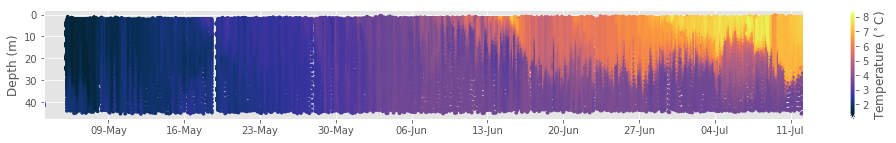

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Temperature'], marker='o', edgecolor='none', cmap=cmocean.cm.thermal)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [38]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['Temperature'].max(), df['Temperature'].min()))


max temp: 8.123
min temp: 1.342


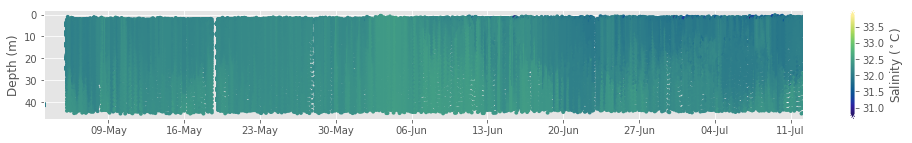

In [39]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Salinity'], marker='o', edgecolor='none', cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [40]:
print("""
max sal: {0:0.4}
min sal: {1:0.4}""".format(df['Salinity'].max(), df['Salinity'].min()))


max sal: 33.86
min sal: 30.81


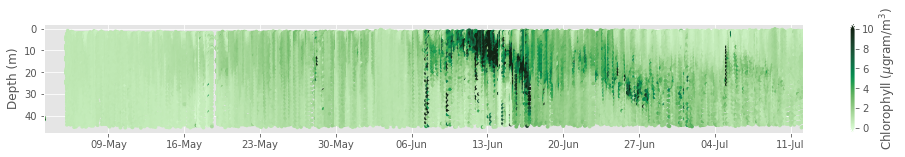

In [41]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Chlorophyll'], marker='o', edgecolor='none', vmin=0, vmax=10, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/m$^3$)')
ax.set_ylabel('Depth (m)');

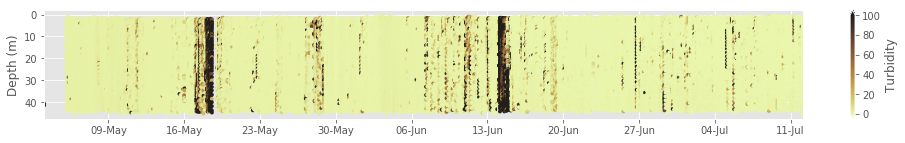

In [42]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Turbidity'], marker='o', edgecolor='none', vmin=0, vmax=100, cmap=cmocean.cm.turbid)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Turbidity')
ax.set_ylabel('Depth (m)');

In [43]:
import seawater as sw
sigmat = sw.dens(s=df['Salinity'],t=df['Temperature'],p=df['depth']) - 1000.

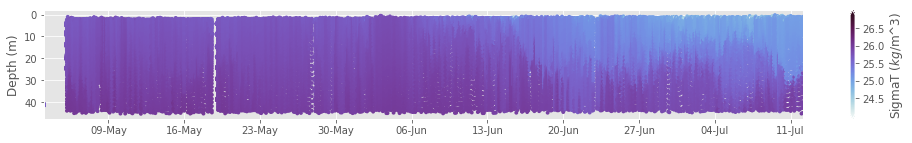

In [44]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=sigmat, marker='o', edgecolor='none', cmap=cmocean.cm.dense)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('SigmaT ($kg/$m^3)')
ax.set_ylabel('Depth (m)');

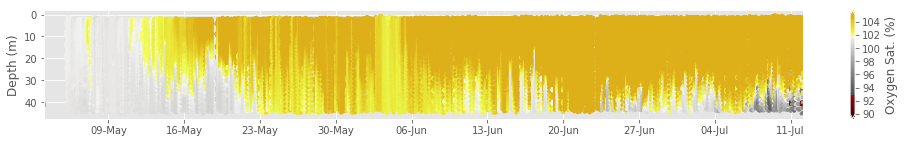

In [45]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['Oxy_Sat'], marker='o', vmin=90, vmax=105, edgecolor='none', cmap=cmocean.cm.oxy)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

**Whats the explanation for the clear pattern of cal profiles having lower values than the full profiles as one goes to depth, especially below the pycno/thermocline**
Initial evaluation is that an oxygen sensor lag may be indicating high values of oxygen concentration deeper in the column than is actually the case based on the calibration profiles (full profiles are higher at equivalent depths...)

Lets investigate this by plotting up a few profiles with the corresponding calibration cast.  We need to do it two ways:
- as a function of depth without time to see how they overlay (features on a sub daily timescale may make this hard)
- as a timeseries for each park and hold to see how long the equilibration takes

Lets choose ~~June 25th~~ ** the last day **

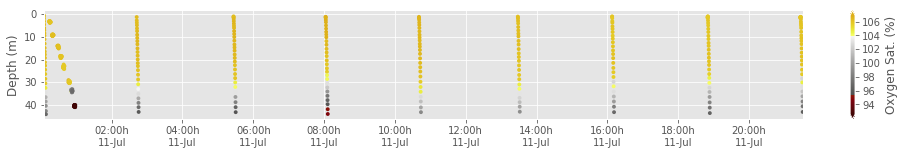

In [46]:
#dfsub = df['2018-06-25':'2018-06-25']
dfsub = df[datetime.datetime.strftime(datetime.date.today() - datetime.timedelta(hours=24),'%Y-%m-%d')]

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(dfsub.index, dfsub['depth'], s=15, c=dfsub['Oxy_Sat'], marker='o', edgecolor='none', cmap=cmocean.cm.oxy)

ax.invert_yaxis()
ax.set_xlim(dfsub.index[0], dfsub.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

In [47]:
#groupby profile id
dfsg = dfsub.groupby('profile_id')

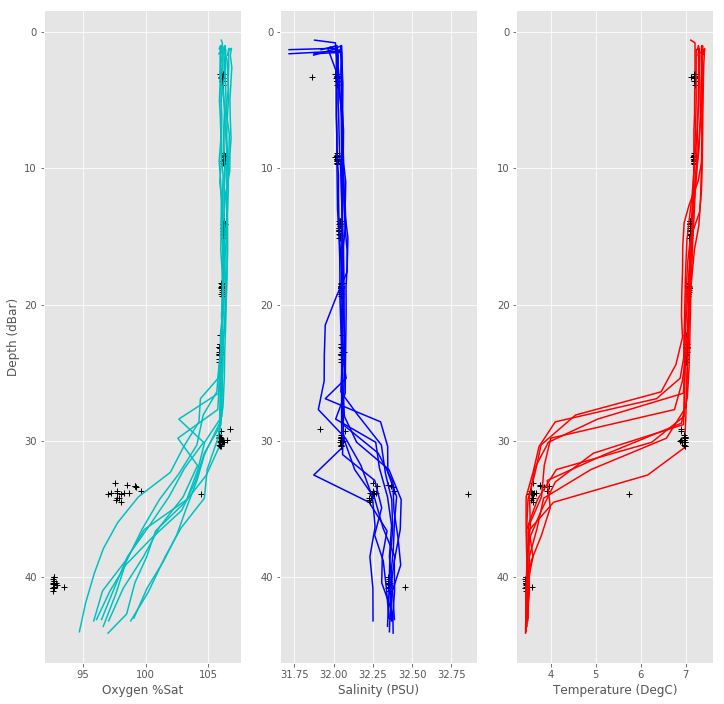

In [48]:
fig, ax = plt.subplots(1,3,figsize=(12, 12))

for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['depth'],'c-')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'],dfsg.get_group(cast)['depth'],'b-')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'],dfsg.get_group(cast)['depth'],'r-')
    else:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'],dfsg.get_group(cast)['depth'],'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'],dfsg.get_group(cast)['depth'],'k+')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'],dfsg.get_group(cast)['depth'],'k+')

ax[0].set_xlabel('Oxygen %Sat')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()

**Top Bin is seems to underestimate... may be contaminated by sfc?** remove it for plotting below.

Also, plot the median value at each calibration park depth instead of every value

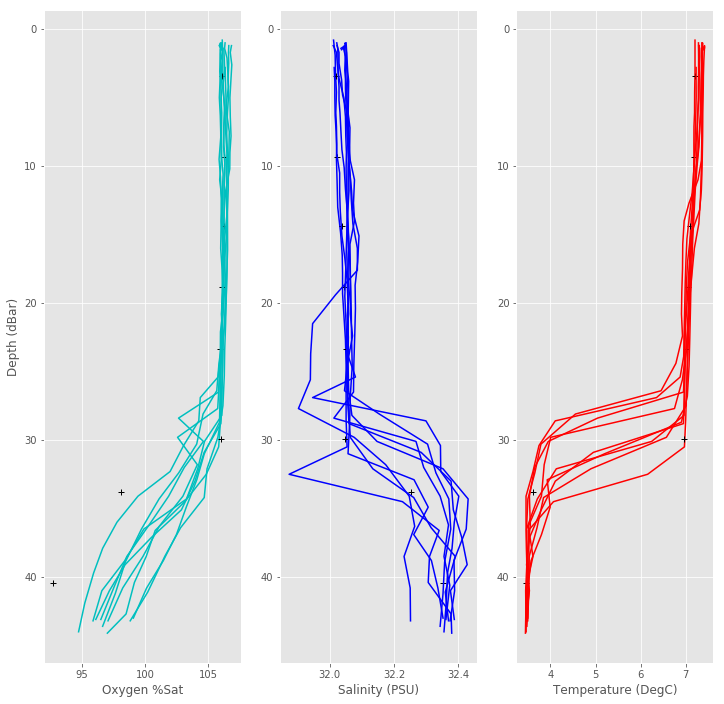

In [49]:
fig, ax = plt.subplots(1,3,figsize=(12, 12))

for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth'].std() > 1:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'][1:],dfsg.get_group(cast)['depth'][1:],'c-')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'][1:],dfsg.get_group(cast)['depth'][1:],'b-')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'][1:],dfsg.get_group(cast)['depth'][1:],'r-')
    else:
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat'].median(),dfsg.get_group(cast)['depth'].median(),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Salinity'].median(),dfsg.get_group(cast)['depth'].median(),'k+')
        cs = ax[2].plot(dfsg.get_group(cast)['Temperature'].median(),dfsg.get_group(cast)['depth'].median(),'k+')

ax[0].set_xlabel('Oxygen %Sat')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()

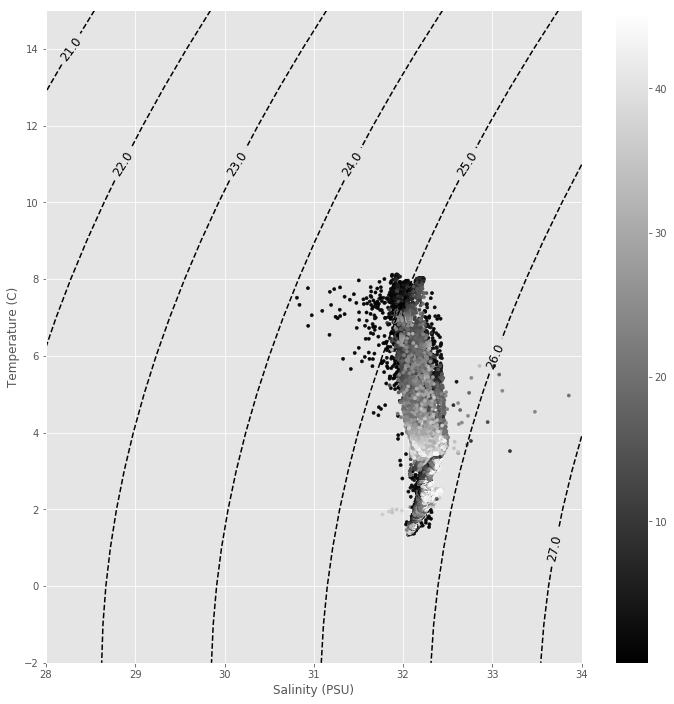

In [50]:
def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

fig = plot_salvtemp(df['Salinity'],df['Temperature'],df['depth'])